# Plot growth rate (doubling time) of cells expressing RNA exporters

# Introduction

## Imports

In [1]:
import sys
import os
import time

import numpy as np
import scipy
import pandas as pd

%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib as mpl
import seaborn as sns

## Set output parameters

In [2]:
# Set pandas display options
pd.set_option('display.max_rows', 30)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 1000)

# Set plot display options
FONTSIZE = 8  # universal fontsize
params = {
    'font.size': FONTSIZE,
    'axes.titlesize': FONTSIZE,
    'axes.labelsize': FONTSIZE,
    'legend.fontsize': FONTSIZE,
    'xtick.labelsize': FONTSIZE,
    'ytick.labelsize': FONTSIZE,
    'font.family': "Helvetica",
    'mathtext.fontset': 'custom',
    'pdf.fonttype': 42,
    'ps.fonttype': 42,
    'figure.dpi': 300
   }
mpl.rcParams.update(params)
sns.set_style("ticks", {'axes.grid' : False})

# Set plot output options
output_dir = "outs/growth_rate"
output_suffix = ""
output_formats = [".png", ".pdf"]

mpl.rc('savefig', dpi=300)

# Define convenience function for saving figures

savefig = True
savefig_args = {"dpi": 300, "bbox_inches": "tight", "pad_inches": 0.1}

def save_figure(fig, name, output_dir=output_dir, output_suffix=output_suffix, output_formats=output_formats, savefig_args=savefig_args):
    if savefig:
        for output_format in output_formats:
            fig.savefig(output_dir + "/" + name + output_suffix + output_format, **savefig_args)
    return None

In [3]:
# Report plot parameters
sns.plotting_context()

{'font.size': 8.0,
 'axes.labelsize': 8.0,
 'axes.titlesize': 8.0,
 'xtick.labelsize': 8.0,
 'ytick.labelsize': 8.0,
 'legend.fontsize': 8.0,
 'legend.title_fontsize': None,
 'axes.linewidth': 0.8,
 'grid.linewidth': 0.8,
 'lines.linewidth': 1.5,
 'lines.markersize': 6.0,
 'patch.linewidth': 1.0,
 'xtick.major.width': 0.8,
 'ytick.major.width': 0.8,
 'xtick.minor.width': 0.6,
 'ytick.minor.width': 0.6,
 'xtick.major.size': 3.5,
 'ytick.major.size': 3.5,
 'xtick.minor.size': 2.0,
 'ytick.minor.size': 2.0}

# Load data

In [4]:
infile = "../preprocessed_data/growth_rate_summary.csv"

df_raw = pd.read_csv(infile, index_col=None)

print(df_raw.shape)
df_raw

(42, 7)


,Condition #,Condition,pID,Time (h),Replicate,Conc (M/mL),Conc live (M/mL)
0,1,293T,NaN,0,1,240000,140000
1,1,293T,NaN,0,2,740000,220000
2,1,293T,NaN,0,3,380000,250000
3,1,293T,NaN,24,1,530000,350000
4,1,293T,NaN,24,2,270000,200000
...,...,...,...,...,...,...,...
37,7,Zeo,NaN,0,2,320000,220000
38,7,Zeo,NaN,0,3,47000,5900
39,7,Zeo,NaN,24,1,700000,150000
40,7,Zeo,NaN,24,2,620000,170000


# Preprocess data

In [5]:
# Calculate live cell percentage
df_raw["Percent_Live"] = 100 * df_raw["Conc live (M/mL)"] / df_raw["Conc (M/mL)"]

In [6]:
# Summarize across replicates

# Calculate mean of replicates
obs = df_raw.groupby(["Condition", "Time (h)"]).mean()

# Calculate variance of replicates
obs["Conc live (M/mL) var"] = df_raw.groupby(["Condition", "Time (h)"]).var()["Conc live (M/mL)"]
obs["Conc (M/mL) var"] = df_raw.groupby(["Condition", "Time (h)"]).var()["Conc (M/mL)"]

obs = obs.reset_index()

obs.head()

,Condition,Time (h),Condition #,Replicate,Conc (M/mL),Conc live (M/mL),Percent_Live,Conc live (M/mL) var,Conc (M/mL) var
0,293T,0,1.0,2.0,453333.333333,203333.333333,51.284179,3.233333e+09,6.653333e+10
1,293T,24,1.0,2.0,356666.666667,263333.333333,76.333566,6.033333e+09,2.253333e+10
2,EPN11-MCP,0,6.0,2.0,270000.000000,163333.333333,60.300619,1.433333e+09,3.000000e+08
3,EPN11-MCP,24,6.0,2.0,300000.000000,210000.000000,71.136174,1.300000e+09,5.200000e+09
4,EPN24-MCP,0,5.0,2.0,213333.333333,116666.666667,53.368421,2.233333e+09,1.033333e+09


# Calculate growth rate

In [7]:
# Create summary dataframe
summary = pd.DataFrame()
summary["Condition"] = obs.Condition.unique()
summary = summary.set_index("Condition")

# Get population abundances at two timepoints

summary["N_t1"] = obs.loc[obs["Time (h)"] == 0].set_index("Condition")["Conc live (M/mL)"]
summary["N_t2"] = obs.loc[obs["Time (h)"] == 24].set_index("Condition")["Conc live (M/mL)"]

summary["N_t1_var"] = obs.loc[obs["Time (h)"] == 0].set_index("Condition")["Conc live (M/mL) var"]
summary["N_t2_var"] = obs.loc[obs["Time (h)"] == 24].set_index("Condition")["Conc live (M/mL) var"]

# Calculate doubling times

delta_t = 24  # difference between timepoints (hours)

summary["t_doubling"] = delta_t / np.log2( summary["N_t2"] / summary["N_t1"])

# Calculate variance of doubling times

summary["t_doubling_var"] = delta_t**2 * ( (summary["N_t2_var"] / summary["N_t2"]**2) + (summary["N_t1_var"] / summary["N_t1"]**2) ) / np.log(2)
summary["t_doubling_std"] = np.sqrt(summary["t_doubling_var"])

summary

,N_t1,N_t2,N_t1_var,N_t2_var,t_doubling,t_doubling_var,t_doubling_std
Condition,,,,,,,
293T,203333.333333,263333.333333,3.233333e+09,6.033333e+09,64.335676,137.288304,11.717009
EPN11-MCP,163333.333333,210000.000000,1.433333e+09,1.300000e+09,66.194100,69.143608,8.315264
EPN24-MCP,116666.666667,213333.333333,2.233333e+09,3.633333e+09,27.563491,202.692010,14.236994
GFP,136666.666667,183333.333333,3.333333e+07,1.233333e+09,56.629456,31.975644,5.654701
Gag-MCP,116666.666667,183333.333333,9.333333e+08,5.333333e+08,36.805486,70.168326,8.376654
No DNA,140000.000000,226666.666667,2.700000e+09,7.233333e+09,34.525150,231.466518,15.214024
Zeo,125300.000000,138000.000000,1.191727e+10,1.552000e+09,172.312470,698.493038,26.429019


# Plot growth rates (doubling times)

In [8]:
# Set well colors

color_exporter_Gag = "#31a354"
color_exporter_engineered = "#756bb1"
color_no_packaging_signal = "#f5b577"
color_no_exporter = "#bdbdbd"
color_no_DNA = "#969696"

index_to_color = {"Gag-MCP": color_exporter_engineered,
                  "EPN24-MCP": color_exporter_engineered,
                  "EPN11-MCP": color_exporter_engineered,
                  "GFP": color_no_exporter,
                  "No DNA": color_no_exporter,
                  "293T": color_no_exporter,
                  "Zeo": color_no_packaging_signal}

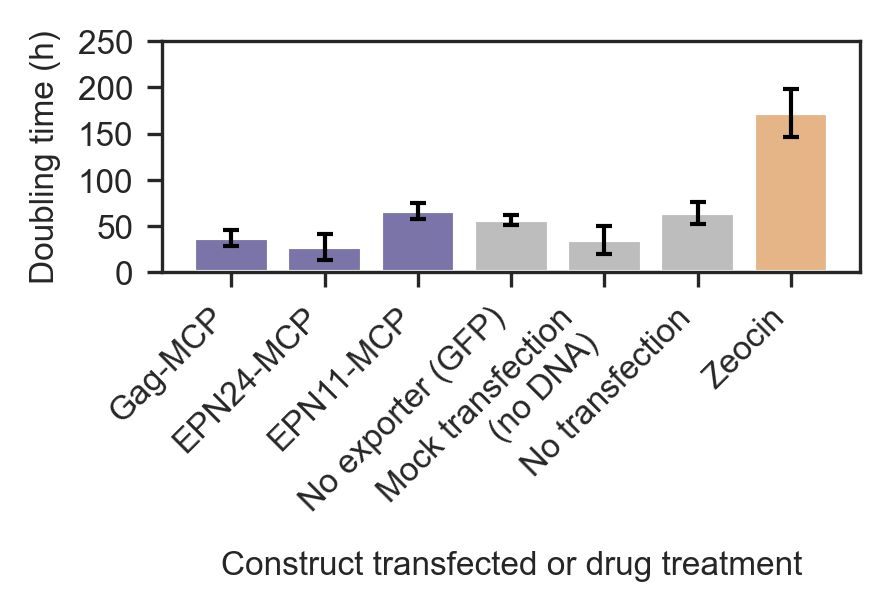

In [9]:
# Plot with colors matching paper

index_ordered = ["Gag-MCP", "EPN24-MCP", "EPN11-MCP", "GFP", "No DNA", "293T", "Zeo"]  # select samples in order

color = [index_to_color[x] for x in index_ordered]

data = summary.loc[index_ordered].reset_index()

fig, ax = plt.subplots(1, 1, figsize=(3,1))

sns.barplot(ax=ax, data=data,
            x="Condition",
            y="t_doubling",
            palette=color)

x_coords = [p.get_x() + 0.5 * p.get_width() for p in ax.patches]
y_coords = [p.get_height() for p in ax.patches]
ax.errorbar(x=x_coords, y=y_coords,
            yerr=data["t_doubling_std"],
            fmt="none",
            c="k",
            capsize=2,
            elinewidth=1)

ax.set_ylim(top=250)
ax.set_yticks([0, 50, 100, 150, 200, 250])

xticklabels = ["Gag-MCP", "EPN24-MCP", "EPN11-MCP", "No exporter (GFP)", "Mock transfection\n(no DNA)", "No transfection", "Zeocin"]
ax.set_xticklabels(xticklabels, rotation=45, ha="right")

ax.set_xlabel("Construct transfected or drug treatment")
ax.set_ylabel("Doubling time (h)")

save_figure(fig, "barplot_growth_rate")

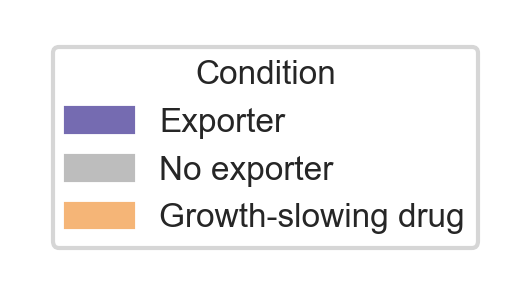

In [10]:
# Plot legend

fig, ax = plt.subplots(1, 1, figsize=(2,1))

labels = ["Exporter", "No exporter", "Growth-slowing drug"]

colors = [color_exporter_engineered,
          color_no_exporter,
          color_no_packaging_signal]

handles = [plt.Rectangle((0,0),1,1, color=c) for c in colors]
plt.legend(handles, labels, title="Condition")

ax.set_xlim(1,2) 
plt.axis('off')

save_figure(fig, "legend_barplot_growth_rate")